In [59]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

import sys

import os
import io 

import pydub

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from pydub import AudioSegment
from pydub.utils import make_chunks
from IPython import display
from collections import namedtuple
from datetime import datetime 
from pathlib import Path
from sklearn import preprocessing

In [60]:
# Load the model.
vgg_model = hub.load('https://tfhub.dev/google/vggish/1')

# Input: 3 seconds of silence as mono 16 kHz waveform samples.
waveform = np.zeros(3 * 16000, dtype=np.float32)

# Run the model, check the output.
embeddings = vgg_model(waveform)
embeddings.shape.assert_is_compatible_with([None, 128])

In [61]:
test_file = namedtuple('ChordList_test', 'filenames targets')
train_file = namedtuple('ChordList_train', 'filenames targets')

In [62]:
test_files = []
train_files = []

test_path = Path('T:\FINAL YEAR PROJECT\PROJECT\Test')
train_path = Path('T:\FINAL YEAR PROJECT\PROJECT\Training')

for item in test_path.glob('**/*'):
    if item.suffix in ['.wav']:
        filenames = str(Path.resolve(item))
        targets = str((os.path.basename(item)).split('_')[0])
        
        test_files.append(test_file(filenames, targets))
        
for item in train_path.glob('**/*'):
    if item.suffix in ['.wav']:
        filenames = str(Path.resolve(item))
        targets = str((os.path.basename(item)).split('_')[0])
        
        train_files.append(train_file(filenames, targets))
        

In [63]:
test_dataframe = pd.DataFrame(test_files)
train_dataframe = pd.DataFrame(train_files)

In [64]:
test_dataframe


,filenames,targets
0,T:\FINAL YEAR PROJECT\PROJECT\Test\Am\Am_Acust...,Am
1,T:\FINAL YEAR PROJECT\PROJECT\Test\Am\Am_Acust...,Am
2,T:\FINAL YEAR PROJECT\PROJECT\Test\Am\Am_Acust...,Am
3,T:\FINAL YEAR PROJECT\PROJECT\Test\Am\Am_Acust...,Am
4,T:\FINAL YEAR PROJECT\PROJECT\Test\Am\Am_Acust...,Am
...,...,...
315,T:\FINAL YEAR PROJECT\PROJECT\Test\G\G_Electri...,G
316,T:\FINAL YEAR PROJECT\PROJECT\Test\G\G_Electri...,G
317,T:\FINAL YEAR PROJECT\PROJECT\Test\G\G_Electri...,G
318,T:\FINAL YEAR PROJECT\PROJECT\Test\G\G_Electri...,G


In [65]:
train_dataframe

,filenames,targets
0,T:\FINAL YEAR PROJECT\PROJECT\Training\Am\Am_a...,Am
1,T:\FINAL YEAR PROJECT\PROJECT\Training\Am\Am_a...,Am
2,T:\FINAL YEAR PROJECT\PROJECT\Training\Am\Am_a...,Am
3,T:\FINAL YEAR PROJECT\PROJECT\Training\Am\Am_a...,Am
4,T:\FINAL YEAR PROJECT\PROJECT\Training\Am\Am_A...,Am
...,...,...
1435,T:\FINAL YEAR PROJECT\PROJECT\Training\G\G_Roc...,G
1436,T:\FINAL YEAR PROJECT\PROJECT\Training\G\G_Roo...,G
1437,T:\FINAL YEAR PROJECT\PROJECT\Training\G\G_Roo...,G
1438,T:\FINAL YEAR PROJECT\PROJECT\Training\G\G_Roo...,G


In [66]:
# Label encode DATA
le_test = preprocessing.LabelEncoder()
label_encoded_df = test_dataframe.copy()
encoded_labels = le_test.fit_transform(label_encoded_df['targets'])
test_df = label_encoded_df.assign(labels=encoded_labels)
        

In [67]:
le_train = preprocessing.LabelEncoder()
label_encoded_df = train_dataframe.copy()
encoded_labels = le_train.fit_transform(label_encoded_df['targets'])
train_df = label_encoded_df.assign(labels=encoded_labels)

In [68]:
test_df

,filenames,targets,labels
0,T:\FINAL YEAR PROJECT\PROJECT\Test\Am\Am_Acust...,Am,0
1,T:\FINAL YEAR PROJECT\PROJECT\Test\Am\Am_Acust...,Am,0
2,T:\FINAL YEAR PROJECT\PROJECT\Test\Am\Am_Acust...,Am,0
3,T:\FINAL YEAR PROJECT\PROJECT\Test\Am\Am_Acust...,Am,0
4,T:\FINAL YEAR PROJECT\PROJECT\Test\Am\Am_Acust...,Am,0
...,...,...,...
315,T:\FINAL YEAR PROJECT\PROJECT\Test\G\G_Electri...,G,7
316,T:\FINAL YEAR PROJECT\PROJECT\Test\G\G_Electri...,G,7
317,T:\FINAL YEAR PROJECT\PROJECT\Test\G\G_Electri...,G,7
318,T:\FINAL YEAR PROJECT\PROJECT\Test\G\G_Electri...,G,7


In [69]:
train_df

,filenames,targets,labels
0,T:\FINAL YEAR PROJECT\PROJECT\Training\Am\Am_a...,Am,0
1,T:\FINAL YEAR PROJECT\PROJECT\Training\Am\Am_a...,Am,0
2,T:\FINAL YEAR PROJECT\PROJECT\Training\Am\Am_a...,Am,0
3,T:\FINAL YEAR PROJECT\PROJECT\Training\Am\Am_a...,Am,0
4,T:\FINAL YEAR PROJECT\PROJECT\Training\Am\Am_A...,Am,0
...,...,...,...
1435,T:\FINAL YEAR PROJECT\PROJECT\Training\G\G_Roc...,G,7
1436,T:\FINAL YEAR PROJECT\PROJECT\Training\G\G_Roo...,G,7
1437,T:\FINAL YEAR PROJECT\PROJECT\Training\G\G_Roo...,G,7
1438,T:\FINAL YEAR PROJECT\PROJECT\Training\G\G_Roo...,G,7


In [111]:
filenames = train_df['filenames']
labels = train_df['labels']
train_ds = tf.data.Dataset.from_tensor_slices((filenames, labels))

filenames = test_df['filenames']
labels = test_df['labels']
test_ds = tf.data.Dataset.from_tensor_slices((filenames, labels))

In [112]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

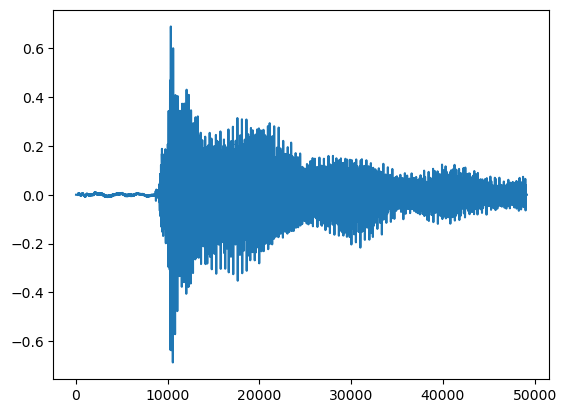

In [113]:
testing_wav_data =  load_wav_16k_mono('T:\IDMT-SMT-CHORDS\IDMT-SMT-CHORDS\C.wav')

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data, rate=16000)


In [114]:
def load_wav_for_map(filename, label):
  return load_wav_16k_mono(filename), label

train_ds = train_ds.map(load_wav_for_map)
test_ds = test_ds.map(load_wav_for_map)


In [115]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label):
  ''' run Vggish to extract embedding from the wav data '''
  embeddings = vgg_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings))

train_ds = train_ds.map(extract_embedding).unbatch()
test_ds = test_ds.map(extract_embedding).unbatch()

In [119]:
val_ds, test_ds =  tf.keras.utils.split_dataset(test_ds, left_size=0.5)

In [120]:
train_ds = train_ds.cache().shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(64).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(64).prefetch(tf.data.AUTOTUNE)

In [121]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [122]:
test_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [123]:
val_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [77]:
!pip install keras_tuner

In [124]:
classes = ["Am","Bb","Bdim","C","Dm","Em","F","G"]

In [125]:
import keras_tuner

def model_builder(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(shape=(128), dtype=tf.float32))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(tf.keras.layers.Dense(len(classes)))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [126]:
tuner = keras_tuner.Hyperband(model_builder,
                             objective='val_accuracy',
                             max_epochs=10,
                             factor=3,
                             project_name='tuning_attempt')

INFO:tensorflow:Reloading Tuner from .\tuning_attempt\tuner0.json


INFO:tensorflow:Reloading Tuner from .\tuning_attempt\tuner0.json


In [127]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [128]:
tuner.search(train_ds, epochs=50, validation_data=val_ds, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit



The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 32 and the optimal learning rate for the optimizer
is 0.0001.



In [143]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(len(classes))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 1024)              132096    
                                                                 
 dense_17 (Dense)            (None, 8)                 8200      
                                                                 
Total params: 140,296
Trainable params: 140,296
Non-trainable params: 0
_________________________________________________________________


In [144]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer=optimizer,
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=5,
                                            restore_best_weights=True)


In [145]:
history = my_model.fit(train_ds,
                       epochs=100,
                       validation_data=val_ds,
                       callbacks=callback)


Epoch 1/100
121/121 [==============================] - 0s 2ms/step - loss: 2.2220 - accuracy: 0.1411 - val_loss: 2.3815 - val_accuracy: 0.0000e+00
Epoch 2/100
121/121 [==============================] - 0s 1ms/step - loss: 2.2189 - accuracy: 0.0957 - val_loss: 2.3157 - val_accuracy: 0.0000e+00
Epoch 3/100
121/121 [==============================] - 0s 1ms/step - loss: 2.1815 - accuracy: 0.0999 - val_loss: 2.2750 - val_accuracy: 0.0000e+00
Epoch 4/100
121/121 [==============================] - 0s 1ms/step - loss: 2.1560 - accuracy: 0.1121 - val_loss: 2.2444 - val_accuracy: 0.0014
Epoch 5/100
121/121 [==============================] - 0s 1ms/step - loss: 2.1346 - accuracy: 0.1148 - val_loss: 2.2198 - val_accuracy: 0.0014
Epoch 6/100
121/121 [==============================] - 0s 1ms/step - loss: 2.1180 - accuracy: 0.1227 - val_loss: 2.1986 - val_accuracy: 0.0056
Epoch 7/100
121/121 [==============================] - 0s 1ms/step - loss: 2.1059 - accuracy: 0.1275 - val_loss: 2.1841 - val_accu

Epoch 58/100
121/121 [==============================] - 0s 1ms/step - loss: 1.7993 - accuracy: 0.3291 - val_loss: 1.9898 - val_accuracy: 0.2493
Epoch 59/100
121/121 [==============================] - 0s 1ms/step - loss: 1.7975 - accuracy: 0.3265 - val_loss: 1.9868 - val_accuracy: 0.2465
Epoch 60/100
121/121 [==============================] - 0s 1ms/step - loss: 1.7919 - accuracy: 0.3324 - val_loss: 1.9872 - val_accuracy: 0.2479
Epoch 61/100
121/121 [==============================] - 0s 1ms/step - loss: 1.7885 - accuracy: 0.3333 - val_loss: 1.9837 - val_accuracy: 0.2521
Epoch 62/100
121/121 [==============================] - 0s 1ms/step - loss: 1.7847 - accuracy: 0.3341 - val_loss: 1.9814 - val_accuracy: 0.2535
Epoch 63/100
121/121 [==============================] - 0s 1ms/step - loss: 1.7787 - accuracy: 0.3376 - val_loss: 1.9857 - val_accuracy: 0.2535
Epoch 64/100
121/121 [==============================] - 0s 1ms/step - loss: 1.7754 - accuracy: 0.3441 - val_loss: 1.9833 - val_accuracy:

In [146]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)


12/12 [==============================] - 0s 847us/step - loss: 1.6900 - accuracy: 0.3908
Loss:  1.6900261640548706
Accuracy:  0.39082059264183044


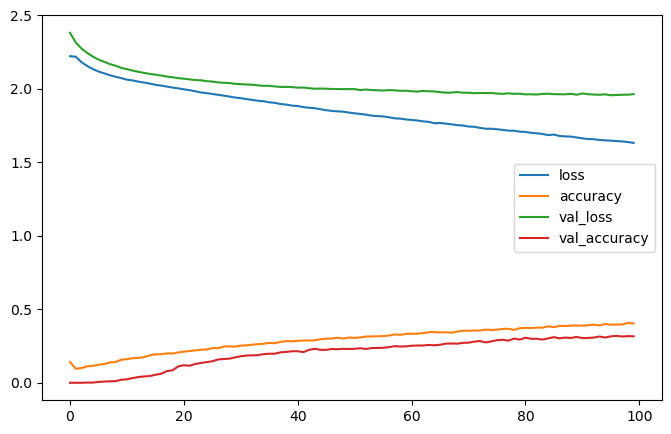

In [147]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()